In [4]:
import matplotlib.cm as cm,numpy as np
import pandas as pd
from geopandas import GeoDataFrame
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm,numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import xlrd
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
warnings.filterwarnings("ignore")

In [6]:
with open("d_mob_study_out.p", "rb") as f:
    d_mob_study_out = pickle.load(f)
geometry=[]
geo_real_home=[]
for usr,pos in tqdm(d_mob_study_out['new_dic_real_home'].items()):
    for single_pos in pos:
        geo_pt=Point(single_pos[1],single_pos[0])
        geo_real_home.append(usr)
        geometry.append(geo_pt)
df=pd.DataFrame(list(zip(geo_real_home,geometry)),columns=['usr','geometry'])
df=df.dropna(how='any')
gdf_real_home = GeoDataFrame(df,geometry=geometry)

100%|██████████| 29677/29677 [00:06<00:00, 4258.04it/s]


In [7]:
df_insee=pd.read_csv('/datastore/complexnet/jlevyabi/geoloc/final.csv')
import re;pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''');new_geo=[]
for geo in tqdm(df_insee.geometry_y):
    matches = pat.findall(geo)
    if matches:
        lst = Polygon([tuple(map(float, m.split())) for m in matches])
    else:
        lst=None
    new_geo.append(lst)

presentable_insee_df=df_insee.drop(["geometry","geometry_y","Unnamed: 0","idINSPIRE",
                                    "geometry_x","nbcar_x","id_x","id_y","idk"],axis=1)
presentable_insee_df=presentable_insee_df.drop("center",axis=1)
presentable_insee_df=presentable_insee_df.convert_objects(convert_numeric=True)
inter= presentable_insee_df.astype(float).round(3)
presentable_insee_df =inter.dropna(how='any')
val_idx = inter.index.isin(presentable_insee_df.index)
presentable_insee_df['geometry']=[new_geo[it] for it,x in enumerate(val_idx) if x]
geo_insee = GeoDataFrame(presentable_insee_df)
geom=geo_insee.geometry
geo_insee["center"]=[poly.centroid for poly in tqdm(geo_insee.geometry)]

100%|██████████| 2277947/2277947 [00:35<00:00, 63995.70it/s]


In [8]:
nb_menages=presentable_insee_df.men
nb_menages_unipers=presentable_insee_df.men_1ind
nb_menages_gt5=presentable_insee_df.men_5ind
nb_menages_2t5=nb_menages-nb_menages_unipers-nb_menages_gt5

people=presentable_insee_df.ind_r
children=presentable_insee_df.ind_age1+presentable_insee_df.ind_age2+presentable_insee_df.ind_age3+presentable_insee_df.ind_age4# From 
adults=people-children # SURE
adults_count_as_one=nb_menages_unipers+nb_menages_gt5+nb_menages_2t5 # 1 By menage SURE
adults_count_as_half=adults-adults_count_as_one # SURE

work_force=presentable_insee_df.ind_age6-presentable_insee_df.ind_age7

income_sum_by_uc=presentable_insee_df.ind_srf

uc=0.3*children+ 0.5*adults_count_as_half+adults_count_as_one
x=np.array(income_sum_by_uc*uc)/(nb_menages*work_force)


Index(['ind_c', 'i_1ind', 'i_age7', 'i_age8', 'i_basr', 'i_prop', 'ind_age1',
       'ind_age2', 'ind_age3', 'ind_age4', 'ind_age5', 'ind_age6', 'ind_age7',
       'ind_age8', 'ind_r', 'ind_srf', 'men', 'men_1ind', 'men_5ind',
       'men_basr', 'men_coll', 'men_occ5', 'men_prop', 'men_surf', 'nbcar_y',
       'income', 'geometry', 'center'],
      dtype='object')

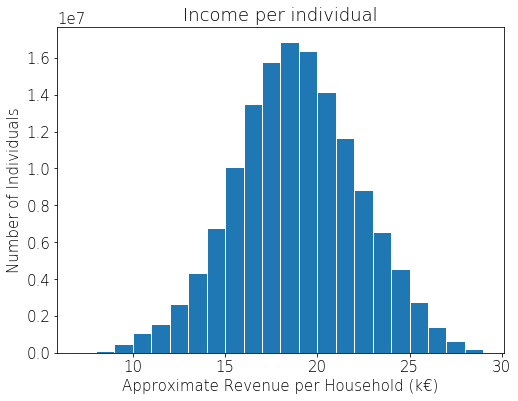

In [29]:
plt.figure(figsize=(8,6))
import matplotlib
x=np.array(income_sum_by_uc)/(presentable_insee_df.ind_r)

font = {'family' : 'normal',
        'weight':"light",
        'size'   : 15}

matplotlib.rc('font', **font)
plt.hist(x//1000,bins=22,histtype='bar',weights=presentable_insee_df.ind_r,edgecolor='white')
plt.xlabel("Approximate Revenue per Household (k€)",weight="light")
plt.ylabel('Number of Individuals',weight="light")
plt.title('Income per individual',weight="light")
plt.savefig("/datastore/complexnet/jlevyabi/ml_soc_econ/icdm18/income_per_indiv_not_log.pdf")
plt.show()

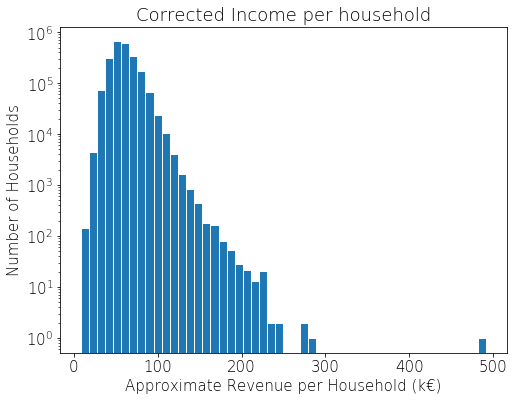

In [74]:
plt.figure(figsize=(8,6))
import matplotlib
x=np.array(income_sum_by_uc*uc)/(nb_menages*work_force)

font = {'family' : 'normal',
        'weight':"light",
        'size'   : 15}

matplotlib.rc('font', **font)

plt.hist(x//1000,bins=50,histtype='bar', edgecolor='white',log=True)
plt.xlabel("Approximate Revenue per Household (k€)",weight="light")
plt.ylabel('Number of Households',weight="light")
plt.title('Corrected Income per household',weight="light")
plt.savefig("/datastore/complexnet/jlevyabi/ml_soc_econ/icdm18/corrected_income.pdf")
plt.show()

In [69]:
x=[0,8,9,10,11,12,13,15,20,25,30,40,50,60,70,80,100,150,200,500]
y=[60850,84163,118472,127544,147071,172326,514180,1791159,2662049,3839342,7507935,4785218,2413332,
   922038,428521,456517,325267,24556,1996]
fake_data=[]
for it in range(len(x)-1):
    for val in np.random.uniform(low=x[it],high=x[it+1],size=y[it]):
        fake_data.append(val)

In [72]:
np.mean(fake_data)

37.93951030159665

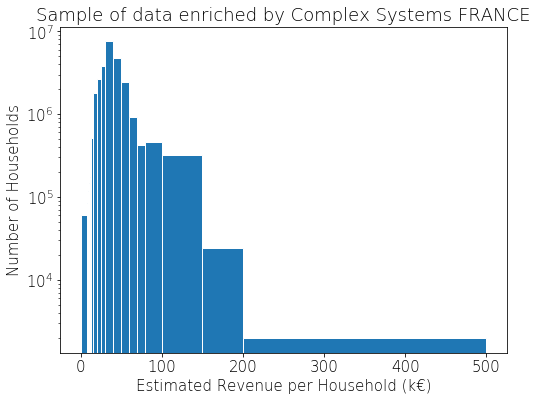

In [73]:
plt.figure(figsize=(8,6))
import matplotlib.pyplot as plt
plt.hist(np.array(fake_data),bins=x,histtype='bar', edgecolor='white',log=True)
plt.xlabel("Estimated Revenue per Household (k€)",weight="light")
plt.ylabel("Number of Households",weight="light")
plt.title ("Sample of data enriched by Complex Systems FRANCE",weight="light")
plt.savefig("/datastore/complexnet/jlevyabi/ml_soc_econ/icdm18/complex_systems.pdf")

In [12]:
print("Average salary per household is %.2f k€"%np.average(x/1000.0,weights=nb_menages))

Average salary per household is 58.36 k€


In [5]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [6]:
print("Approx %.2f"%gini(x))
print("Biased %.2f"%gini(presentable_insee_df.income))

Approx 0.13
Biased 0.09


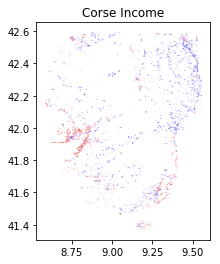

In [4]:
geo_insee_center=geo_insee.copy()
geo_insee_center["geometry"]=geo_insee_center["center"]
geo_insee_center=geo_insee_center.drop("center",axis=1)
geo_insee_corse=geo_insee.head(12000)
geo_insee_corse.plot(column="income",cmap="seismic")
plt.title("Corse Income")
plt.show()

In [5]:
from geopandas import sjoin
gdf_real_home.crs = geo_insee.crs
usrs_with_insee_income = sjoin(gdf_real_home,geo_insee, how="inner", op='within')

In [6]:
dic_insee={}
for it,row in tqdm(usrs_with_insee_income.iterrows()):
    if row.usr not in dic_insee:
        dic_insee[row.usr]=[]
    income=row.income
    own_rat=(row.men_prop+0.0)/row.ind_r
    dic_insee[row.usr].append([row.geometry,income,own_rat])
for key,val in tqdm(dic_insee.items()):
    dic_insee[key]=GeoDataFrame(val,columns=["geotw","income","owner_ratio"])

451030it [04:13, 1777.45it/s]
100%|██████████| 28035/28035 [01:11<00:00, 394.02it/s]


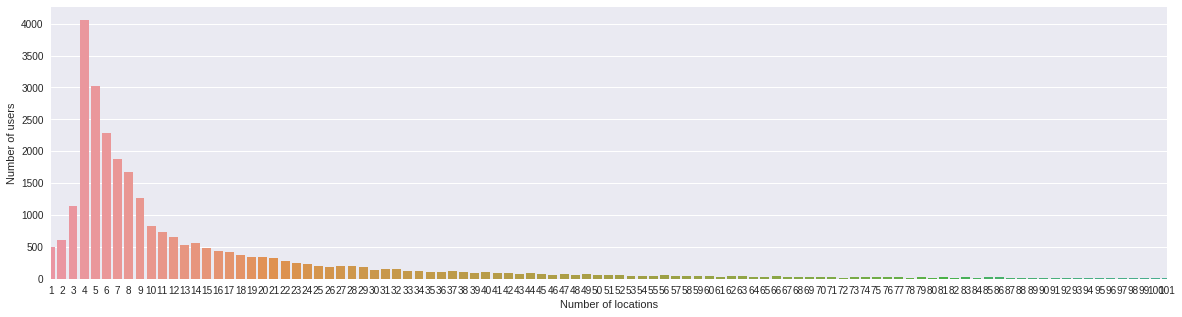

In [7]:
import seaborn as sns
from collections import Counter
sns.plt.figure(figsize=(20,5))
nb_locs=[v.shape[0] for k,v in dic_insee.items() ]
pd_locs = pd.DataFrame(list(Counter(nb_locs).items()))
pd_locs.columns =["nb_locs","Count"]
pd_locs = pd_locs.sort_values(['Count'],ascending=False).reset_index(drop=True)
sns.barplot(list(pd_locs.nb_locs),list(pd_locs.Count))
sns.plt.xlim([0,100])
sns.plt.xlabel('Number of locations')
sns.plt.ylabel('Number of users')
sns.plt.show()

In [8]:
more_locs=[v.shape[0] for v in (dic_insee.values()) ]
dic_insee_avg=pd.DataFrame([v.mean() for v in (dic_insee.values()) ],columns=["income","owner_ratio"])
dic_insee_avg["usr"]=list(dic_insee.keys())
get_mode = lambda x: x.value_counts(dropna=True).index[0]
get_mode.__name__ = "most frequent"
dic_insee_mode=pd.DataFrame([v[["income","owner_ratio"]].agg(get_mode) for v in (dic_insee.values())],
                            columns=["income","owner_ratio"])
dic_insee_mode["usr"]=list(dic_insee.keys())

In [ ]:
# import scipy.stats as st
import seaborn as sns
sns.plt.figure(figsize=(20,7))

sns.plt.subplot(121)
sns.regplot(dic_insee_avg.income,dic_insee_avg.owner_ratio,scatter_kws={"s": 10,'alpha':0.3})
rsquare = st.pearsonr(dic_insee_avg.income,dic_insee_avg.owner_ratio)[0]**2
sns.plt.annotate("$R^2=%.2f$"%round(rsquare,2), xy=(0.1, 0.9), xycoords='axes fraction')

sns.plt.subplot(122)
sns.regplot(dic_insee_mode.income,dic_insee_mode.owner_ratio,scatter_kws={"s": 10,'alpha':0.3})
rsquare = st.pearsonr(dic_insee_mode.income,dic_insee_mode.owner_ratio)[0]**2
sns.plt.annotate("$R^2=%.2f$"%round(rsquare,2), xy=(0.1, 0.9), xycoords='axes fraction')

sns.plt.show()

In [10]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/datastore/complexnet/jlevyabi/network_representation/python_scripts/')
import helpers_ses_prediction as hsp

In [11]:
dic_insee_avg["income_class"]=hsp.ses_classify(dic_insee_avg.income)
dic_insee_avg["owner_ratio_class"]=hsp.ses_classify(dic_insee_avg.owner_ratio)
dic_insee_avg['ses_class'] = list(zip(dic_insee_avg.income_class, dic_insee_avg.owner_ratio_class))


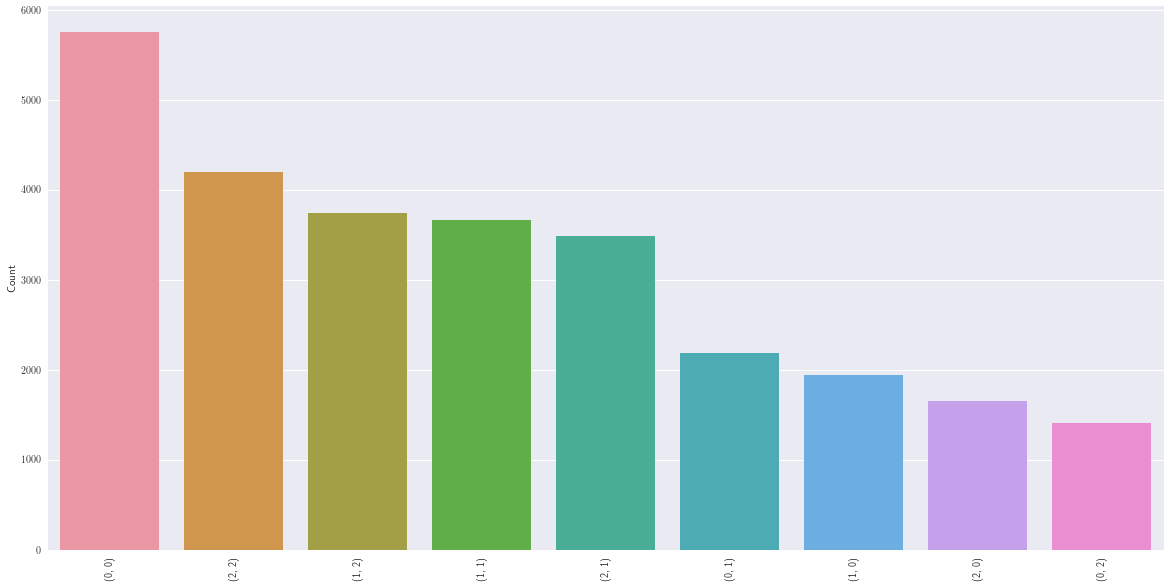

In [12]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

sns.plt.figure(figsize=(20,10))
from collections import Counter
count_class=Counter([str(x) for x in dic_insee_avg.ses_class])
pd_df = pd.DataFrame(list(count_class.items()))
pd_df.columns =["Class","Count"]
pd_df = pd_df.sort_values(['Count'],ascending=False).reset_index(drop=True)

sns.barplot(list(pd_df.Class),list(pd_df.Count))
sns.plt.ylabel("Count")
sns.plt.xticks(rotation=90)
sns.plt.show()

In [13]:
dic_insee_avg.head()

,income,owner_ratio,usr,income_class,owner_ratio_class,ses_class
0,10132.371864,0.086084,1263741576,0,0,"(0, 0)"
1,17004.969963,0.303846,951534680,0,2,"(0, 2)"
2,15162.799875,0.261673,611969427,0,2,"(0, 2)"
3,10021.022389,0.082664,1055585449,0,0,"(0, 0)"
4,17031.747000,0.116866,123306709,0,0,"(0, 0)"


In [14]:
%aimport tqdm
usr_text=hsp.load_text_data();
d100=pickle.load(open("/home/jlevyabi/seacabo/data_files/spec_corrected_clusters_only_pos_entries_200.p","rb"))
usr_text=hsp.get_cluster_info(d100,usr_text);
usr_text['id'] = usr_text.index
tweets_id=[int(idx) for idx in usr_text.id]
usr_text["id"]=tweets_id
usr_text.drop("id",axis=1,inplace=True)
dic_insee_avg["id"]=dic_insee_avg["usr"]

Loading Tweets ...


100%|██████████| 103392/103392 [01:45<00:00, 977.80it/s] 


In [15]:
nb_class=2
dic_insee_avg["income_class"]=hsp.ses_classify(dic_insee_avg.income,nb_class)
dic_insee_avg["owner_ratio_class"]=hsp.ses_classify(dic_insee_avg.owner_ratio,nb_class)
dic_insee_avg['ses_class'] = list(zip(dic_insee_avg.income_class, dic_insee_avg.owner_ratio_class))
usr_text,ses_text=hsp.ses_and_text(usr_text,d100,dic_insee_avg,);

Merging SES and text...


100%|██████████| 103392/103392 [01:42<00:00, 1005.23it/s]


In [16]:
dic_insee_avg.head()

,income,owner_ratio,usr,income_class,owner_ratio_class,ses_class,id
0,10132.371864,0.086084,1263741576,0,0,"(0, 0)",1263741576
1,17004.969963,0.303846,951534680,0,1,"(0, 1)",951534680
2,15162.799875,0.261673,611969427,0,1,"(0, 1)",611969427
3,10021.022389,0.082664,1055585449,0,0,"(0, 0)",1055585449
4,17031.747000,0.116866,123306709,0,0,"(0, 0)",123306709


In [21]:
from sklearn.metrics import classification_report,f1_score
nb_class=3
dic_insee_avg["income_class"]=hsp.ses_classify(dic_insee_avg.income,nb_class)
dic_insee_avg["owner_ratio_class"]=hsp.ses_classify(dic_insee_avg.owner_ratio,nb_class)
dic_insee_avg['ses_class'] = list(zip(dic_insee_avg.income_class, dic_insee_avg.owner_ratio_class))

for nb_locs in [1]:#list(range(1,10))+list(range(11,30,4)):
    
    print("Minimal Locs %d ..."%(nb_locs))
    
    ses_text_copy=ses_text.drop(["income","owner_ratio","income_class","owner_ratio_class","ses_class"],axis=1)
    ses_text_filter_loc=ses_text_copy[[dic_insee[usr].shape[0]>nb_locs for usr in ses_text.id]]

    ses_text_filter_loc=pd.merge(ses_text_filter_loc,dic_insee_avg,on="id",how="inner")
    
    text_fts_full=np.vstack([np.hstack(sample.as_matrix()).reshape((1,250)) if not(sample[0] is None) else np.zeros((1,250))
                            for it,sample in (ses_text_filter_loc[["avg_w2v","cfd"]].iterrows())])
    text_fts_cfd=np.vstack([np.hstack(sample.as_matrix()).reshape((1,200))
                            for it,sample in (ses_text_filter_loc[["cfd",]].iterrows())])
    text_fts_w2v=np.vstack([np.hstack(sample.as_matrix()).reshape((1,50)) if not(sample[0] is None)else np.zeros((1,50))
                            for it,sample in (ses_text_filter_loc[["avg_w2v",]].iterrows())])
    
    y=np.copy(ses_text_filter_loc.income_class);y[y==1]=999;y[y==2]=1;
    z=np.copy(ses_text_filter_loc.owner_ratio_class);z[z==1]=999;z[z==2]=1
    
    model_cfd,score_cfd=hsp.log_ses_class(txt=text_fts_cfd[(z!=999) & (y!=999) ],
                        class_income=z[(z!=999) & (y!=999) ],
                        compare_metrics=classification_report)
    model_w2v,score_w2v=hsp.log_ses_class(txt=text_fts_w2v[(z!=999) & (y!=999) ],
                        class_income=z[(z!=999) & (y!=999) ],
                        compare_metrics=classification_report)
    model_full,score_full=hsp.log_ses_class(txt=text_fts_full[(z!=999) & (y!=999) ],
                        class_income=z[(z!=999) & (y!=999) ],
                        compare_metrics=classification_report)
    
    
    

Minimal Locs 1 ...
Optimization terminated successfully.
         Current function value: 0.586212
         Iterations 9
             precision    recall  f1-score   support

          0       0.70      0.68      0.69      1281
          1       0.60      0.62      0.61       972

avg / total       0.66      0.65      0.66      2253

Optimization terminated successfully.
         Current function value: 0.619254
         Iterations 6
             precision    recall  f1-score   support

          0       0.69      0.72      0.71      1273
          1       0.62      0.58      0.60       980

avg / total       0.66      0.66      0.66      2253

Optimization terminated successfully.
         Current function value: 0.578489
         Iterations 9
             precision    recall  f1-score   support

          0       0.72      0.72      0.72      1255
          1       0.64      0.65      0.65       998

avg / total       0.69      0.69      0.69      2253



In [24]:
print(model_cfd.predict(np.array(ses_text_filter_loc.iloc[0].cfd)))
print(model_w2v.predict(np.array(ses_text_filter_loc.iloc[0].avg_w2v)))
print(model_full.predict(np.hstack(ses_text_filter_loc.iloc[0][["avg_w2v","cfd"]].as_matrix()).reshape((1,250))))

[ 0.45379664]
[ 0.44334723]
[ 0.40161406]


In [62]:
#hsp.log_ses_class(text_fts[(z!=999) & (y!=999)],z[(z!=999) & (y!=999)])

Optimization terminated successfully.
         Current function value: 0.526931
         Iterations 11
             precision    recall  f1-score   support

          0       0.76      0.85      0.80       495
          1       0.65      0.51      0.57       274

avg / total       0.72      0.73      0.72       769



In [ ]:
ses_text.head(1)

In [26]:
linkedin_data=pd.read_csv(header=-1,names=["id","summary"],
                          filepath_or_buffer="/datastore/complexnet/jlevyabi/"+
                          "ml_soc_econ/data_files/UKSOC_rep/linkedin/linkedin_usrs_summary_unique.txt",sep="\t")

In [27]:
linked_insee_text=pd.merge(ses_text,linkedin_data,how="inner",on="id")

In [28]:
linked_insee_text.shape

(1468, 11)

In [29]:
linked_insee_text.head()

,id,tweet,cfd_200,avg_w2v,cfd,income,owner_ratio,income_class,owner_ratio_class,ses_class,summary
0,865361,je kiffe et cersei en brune gtgtgt tout arnold...,"[0.00028818443804, 0.0100864553314, 0.00028818...","[2.04994, 3.62359, 4.55434, -0.483394, 0.18779...","[0.00028818443804, 0.0100864553314, 0.00028818...",17557.919708,0.312639,0,1,"(0, 1)",Cavalier western • fétichiste du télémétrique ...
1,1044331,joyeux anniversaire to max bautin joyeux anniv...,"[0.0, 0.0140186915888, 0.0, 0.0, 0.0, 0.004672...","[1.16274, 2.47023, 3.3425, 0.386675, -1.71073,...","[0.0, 0.0140186915888, 0.0, 0.0, 0.0, 0.004672...",23166.180000,0.239174,1,1,"(1, 1)",— Tweets are my own — @Caissedesdepots // CEO...
2,1149311,thank you la suisse fait tourner et ça plane p...,"[0.000915750915751, 0.00732600732601, 0.004578...","[-0.663623, 0.479236, 2.03202, 0.494686, -1.22...","[0.000915750915751, 0.00732600732601, 0.004578...",15712.906222,0.146853,0,0,"(0, 0)","Geek of the dead, cofounder/CTO of @afrostream..."
3,1155631,ah ah ce n est sans doute pas le jour pour ça ...,"[0.0, 0.00820793433653, 0.00136798905609, 0.0,...","[1.94432, 3.03874, 3.43168, -0.228598, -0.0626...","[0.0, 0.00820793433653, 0.00136798905609, 0.0,...",23843.617900,0.204531,1,0,"(1, 0)","Do not follow me, I'm lost too. Lost in Paris,..."
4,1487491,en attendant la premiere reunion de la journee...,"[0.0, 0.0138512496236, 0.00150557061126, 0.000...","[1.82439, 2.90637, 3.95227, 0.178343, -0.93634...","[0.0, 0.0138512496236, 0.00150557061126, 0.000...",24868.829750,0.254449,1,1,"(1, 1)","Consultant, stratégies marketing du Travel. Cr..."


In [33]:
data_linkedin_not_void=pd.read_csv("~/seacabo/data_files/salary_databases/linkedin_prof_jdn.csv",sep="\t",header=0)
real_data_linkedin_not_void=data_linkedin_not_void[data_linkedin_not_void.salary_0<12000]
real_data_linkedin_not_void.head(2)

,Unnamed: 0,id,summary,lkd,job_0,salary_0,job_1,salary_1,job_2,salary_2,job_3,salary_3,job_4,salary_4,job_5,salary_5,job_6,salary_6
0,5,100017919,press officer-eu parliament-i express only per...,"[('office', 2500.0)]",office,2500.000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
1,13,100032180,multichannel/multicanal/open innovation/social...,"[('agent', 3038.625)]",agent,3038.625,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


In [34]:
linked_in_sal_insee=pd.merge(real_data_linkedin_not_void,linked_insee_text,on="id",how="inner")

In [75]:
linked_in_sal_insee.head(2)

,Unnamed: 0,id,summary_x,lkd,job_0,salary_0,job_1,salary_1,job_2,salary_2,...,tweet,cfd_200,avg_w2v,cfd,income,owner_ratio,income_class,owner_ratio_class,ses_class,summary_y
0,21,100071422,patriote francais * catholique * paterfamilias...,"[('juriste', 4705.076923076923)]",juriste,4705.076923,NaN,0.0,NaN,0.0,...,le mec insulte la caissiere de chez zara parce...,"[0.000637755102041, 0.00956632653061, 0.000637...","[2.52295, 3.21735, 4.61782, -0.575525, -0.6990...","[0.000637755102041, 0.00956632653061, 0.000637...",19826.57800,0.235344,1,1,"(0, 1)",Patriote français • Catholique • PaterFamilias...
1,66,1002444511,sportif retraite et futur journaliste. [?],"[('journaliste', 1940.0), ('sportif', 2459.0)]",journaliste,1940.000000,sportif,2459.0,NaN,0.0,...,c est tellement ouvert ce mondial que moi auss...,"[0.0, 0.0116356382979, 0.0, 0.0, 0.00299202127...","[2.05258, 3.30223, 4.1513, -0.585089, 0.941333...","[0.0, 0.0116356382979, 0.0, 0.0, 0.00299202127...",24377.06511,0.198856,0,0,"(1, 0)",Sportif retraité et futur journaliste. ❤️💙


In [74]:
f=open("why_not_journal_du_net.txt","w")
for it,row in linked_in_sal_insee.iterrows():
    ro=(row.summary_x+"\n"+str(row.job_0)+", "+str(row.salary_0)+", "
        +str(row.income)+", "+str(row.owner_ratio)+"\n\n")
    f.write(ro)
f.close()

In [66]:
from sklearn.metrics import classification_report,f1_score
nb_class=2
linked_in_sal_insee["income_class"]=hsp.ses_classify(linked_in_sal_insee.salary_0,nb_class)
#linked_in_sal_insee["owner_ratio_class"]=hsp.ses_classify(linked_in_sal_insee.owner_ratio,nb_class)
#linked_in_sal_insee['ses_class'] = list(zip(linked_in_sal_insee.income_class, linked_in_sal_insee.owner_ratio_class))

text_fts_full=np.vstack([np.hstack(sample.as_matrix()).reshape((1,250)) if not(sample[0] is None) else np.zeros((1,250))
                         for it,sample in (linked_in_sal_insee[["avg_w2v","cfd"]].iterrows())])
text_fts_cfd=np.vstack([np.hstack(sample.as_matrix()).reshape((1,200))
                        for it,sample in (linked_in_sal_insee[["cfd",]].iterrows())])
text_fts_w2v=np.vstack([np.hstack(sample.as_matrix()).reshape((1,50)) if not(sample[0] is None)else np.zeros((1,50))
                        for it,sample in (linked_in_sal_insee[["avg_w2v",]].iterrows())])
    
y=np.copy(linked_in_sal_insee.income_class);#y[y==1]=999;y[y==2]=1;
#z=np.copy(linked_in_sal_insee.owner_ratio_class);#z[z==1]=999;z[z==2]=1
    
#model_cfd,score_cfd=hsp.log_ses_class(text_fts_cfd,y,compare_metrics=classification_report)
model_w2v,score_w2v=hsp.log_ses_class(text_fts_w2v,y,compare_metrics=classification_report)
#model_full,score_full=hsp.log_ses_class(text_fts_full,y,compare_metrics=classification_report)

Optimization terminated successfully.
         Current function value: 0.559176
         Iterations 7
             precision    recall  f1-score   support

          0       0.44      0.44      0.44        36
          1       0.41      0.41      0.41        34

avg / total       0.43      0.43      0.43        70



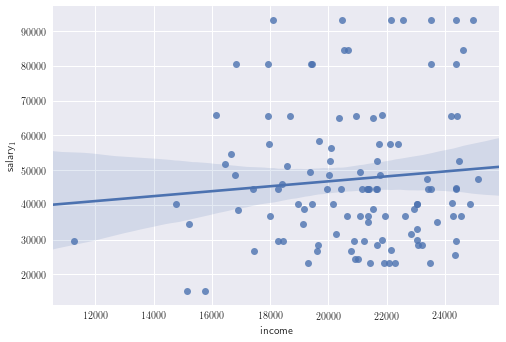

In [47]:
import seaborn as sns
x=linked_in_sal_insee.income[(linked_in_sal_insee.salary_1!=0)& (linked_in_sal_insee.salary_1<10000)]
y=linked_in_sal_insee.salary_1[(linked_in_sal_insee.salary_1!=0)& (linked_in_sal_insee.salary_1<10000)]*12
sns.regplot(x,y)
sns.plt.show()

In [68]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


In [83]:
for name, classif in zip(names, classifiers):
    _,score_1=hsp.clf_ses_class(txt=text_fts[(z!=999) & (y!=999) & (y==z)],
                              class_income=z[(z!=999) & (y!=999) & (y==z)],
                              clf=classif,rd=4,norm=True)
    _,score_2=hsp.clf_ses_class(txt=text_fts[(z!=999) & (y!=999) & (y==z)],
                              class_income=z[(z!=999) & (y!=999) & (y==z)],
                              clf=classif,rd=4,norm=False)
    print("%s ... Normed %.2f Un_Normed %.2f"%(name,score_1,score_2))

Nearest Neighbors ... Normed 0.63 Un_Normed 0.63
Linear SVM ... Normed 0.69 Un_Normed 0.65
RBF SVM ... Normed 0.65 Un_Normed 0.65
Gaussian Process ... Normed 0.62 Un_Normed 0.67
Decision Tree ... Normed 0.65 Un_Normed 0.65
Random Forest ... Normed 0.65 Un_Normed 0.66
Neural Net ... Normed 0.65 Un_Normed 0.65
AdaBoost ... Normed 0.67 Un_Normed 0.67
Naive Bayes ... Normed 0.58 Un_Normed 0.58
QDA ... Normed 0.58 Un_Normed 0.57


In [127]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
regr = linear_model.LinearRegression(normalize=True)

X_train, X_test, y_train, y_test = train_test_split(text_fts_full, ses_text_filter_loc.owner_ratio, random_state=4)

# Train the model using the training sets
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test,y_pred))


Mean squared error: 0.01
Variance score: 0.13
